<a href="https://colab.research.google.com/github/dab0012/olivia/blob/master/Olivia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OLIVIA
**Open-source Library Indexes Vulnerability Identification and Analysis**

The use of centralized library repositories to reduce development times and costs is universal, in virtually all languages and types of software projects. Due to the transitivity of dependencies, the appearance of a single defect in the repository can have extensive and difficult-to-predict effects on the ecosystem. These defects cause functional errors or performance or security problems. The risk is difficult to grasp for developers, who only explicitly import a small part of the dependencies.

OLVIA uses an approach based on the vulnerability of the dependency network of software packages, which measures how sensitive the repository is to the random introduction of defects. The goals of the model are  to contribute to the understanding of propagation mechanisms of software defects and to study feasible protection strategies. This can benefit multiple parties:

* **Centralised package managers**, to establish policies and manual or automatic control processes that improve the security and stability of the repositories.
* **Software developers** in general, to assess the different risks introduced by the dependencies used in their projects, and **package developers** in particular to understand their responsibility on the ecosystem.
* Developers of **continuous quality tools**, to define the concept of vulnerability based on the modeling of the network of package dependencies.
---

**Author**: Daniel Setó Rey

https://github.com/dsr0018/olivia

**License**: Olivia and this notebook are published under a MIT [license](https://github.com/dsr0018/olivia/blob/master/LICENSE). The information of dependencies has been obtained from the libraries.io [data snapshots](https://libraries.io/data) (by Tidelift).

---

*This notebook is part of a user guide series that cover in detail the operation of the library.*
*This time we treat the basic operations of loading/creating models and dealing with package properties and metrics.*



## Setup runtime environment

In [1]:
from google.colab import drive

# Mount Gdrive
drive.mount("/content/gdrive")

# Prepare test folders
!mkdir "/content/gdrive/My Drive/test_olivia"
%cd "/content/gdrive/My Drive/test_olivia"

# Download source code from github
!git clone https://github.com/dab0012/olivia
%cd olivia

# Install requeriments
! pip install -r requirements.txt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘/content/gdrive/My’: Operation not supported
mkdir: cannot create directory ‘Drive/test_olivia’: No such file or directory
[Errno 2] No such file or directory: '/content/gdrive/My Drive/test_olivia'
/content
fatal: destination path 'olivia' already exists and is not an empty directory.
/content/olivia
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



## A - Basic model usage

[01 - Load model](#01---Load-model)&ensp;|&ensp;[02 - Package properties](#02---Package-properties)&ensp;|&ensp;[03 - Package metrics](#03---Package-metrics)&ensp;|&ensp;[04 - Custom models](#04---Custom-models) 

*OliviaNetwork* is essentially a directed graph with some additional structures to facilitate working with metrics in large dependency networks. The model can be built from a NetworkX directed network or from a file in adjacency list format.

### 01 - Load model

Load a pre-built model from file. This one is based in a snapshot of the Python Package Index (https://pypi.org/) from 2020-01 (data from https://libraries.io/):

In [2]:
from olivia.model import OliviaNetwork

In [3]:
pypi = OliviaNetwork(r'data/pypi-2020-01-12.olv')

As expected, *len()* returns the number of the packages in the network:

In [4]:
len(pypi)

50766

You may iterate over package names:

In [5]:
# Packages in PyPI starting with 'zai'
for package in pypi:
    if package[0:3]=='zai':
        print(package)

zaim
zaifer
zaius-export
zaidan


### 02 - Package properties

Access via *getitem* returns a special view object:

In [6]:
pypi['networkx']

*PackageInfoView* contains methods returning stats for specific packages. For example, direct dependants are other packages that import networkx in their code:

In [7]:
print(f"NetworkX has {len(pypi['networkx'].direct_dependants())} direct dependants")  

NetworkX has 372 direct dependants


Packages may depend on NetworkX not only directly, but also via transitive dependencies:

![Dependants and transitive dependants](docs/img/dependants.png "Transitive dependencies")  
<br>

In [8]:
print(f"NetworkX has {len(pypi['networkx'].transitive_dependants())} transitive dependants (includes direct dependants)")

NetworkX has 589 transitive dependants (includes direct dependants)


Packages are returned as sets so we may apply the usual set operators. For example, these packages depend on NetworkX but do not explicitly import it:

In [9]:
print(pypi['networkx'].transitive_dependants() - pypi['networkx'].direct_dependants())

{'girder-large-image', 'sos-pbs', 'score.webassets', 'janis-pipelines.unix', 'sos-papermill', 'score.http', 'biobb-structure-utils', 'penaltymodel-maxgap', 'followthemoney-enrich', 'histomicsui', 'janis-pipelines.pipelines', 'score.js', 'penaltymodel-cache', 'container-service-extension', 'nodepool', 'jupyter_marvinjs', 'emmaa', 'termlink', 'nslsii', 'IndicoIo', 'dhlab', 'dvc-cc', 'brainio', 'fluidasserts', 'impulse', 'cinderlib', 'DeepSR', 'biobb-io', 'rasl', 'tomaster', 'multicolorfits', 'mosaik.SimConfig', 'nova-powervm', 'Orange-Spectroscopy', 'ndexncipidloader', 'xd-cwl-utils', 'tensorfont', 'niflow-nipype1-workflows', 'ndexgenehancerloader', 'score.auth', 'biosteam', 'mosaik.Demo-semver', 'dumpshmamp-sha1n', 'dumpshmamp', 'austen', 'bespin-cli', 'axibot', 'medImgProc', 'django-phenotype-ontologies', 'sevenbridges-cwl-draft2-upgrader', 'ironic-python-agent-builder', 'score.session', 'fastr', 'aperturesynth', 'followthemoney-util', 'dival', 'networking-powervm', 'score.tpl', 'odess

Lets pick one of them and check its dependencies, the packages on which it depends:

In [10]:
pypi['nobrainer'].direct_dependencies()

{'click', 'nibabel', 'numpy', 'scikit-image', 'tensorflow-probability'}

NetworkX is not a direct dependency but a transitive one:

In [11]:
pypi['nobrainer'].transitive_dependencies()

{'PyWavelets',
 'bz2file',
 'click',
 'cloudpickle',
 'decorator',
 'gast',
 'matplotlib',
 'networkx',
 'nibabel',
 'numpy',
 'pillow',
 'scikit-image',
 'scipy',
 'six',
 'tensorflow-probability'}

### 03 - Package metrics

**REACH** of a package *u* is the number of transitive dependents of *u* plus 1.

In [12]:
pypi['networkx'].reach()

590

REACH represents the number of packages in the network that could be affected by the occurrence of a defect in *u*, like a bug or a security vulnerability. A bug in networkx could affect 590 packages, including NetworkX.

You may calculate REACH package by package, as in the previous example. However, this involves many redundant computations and is very slow. OLIVIA provides efficient methods to calculate REACH for all the nodes in the network.

In [13]:
from olivia.packagemetrics import Reach
pypi_reach = pypi.get_metric(Reach)

Computing Reach



*OliviaModel.get_metric(...)* returns a *MetricStats* object with the results of the computation. *get_metric(...)* accepts as parameter classes implementing the *compute()* method, such as the ones in *olivia.packagemetrics*

In [14]:
pypi_reach

In [15]:
pypi_reach['networkx']

590

Once calculated through *get_metric*, the *MetricStats* object is cached into the *OliviaNetwork* model. In this way, other complex algorithms that use large metric results are freed from managing each one on their own. 

So there is really no need to store the results into an independent variable like we did.

In [16]:
pypi_reach = pypi.get_metric(Reach)

Reach retrieved from metrics cache


In [17]:
pypi.get_metric(Reach)['networkx']

Reach retrieved from metrics cache


590

The management of the cache is semi-automatic. You can request a value from a network-wide metric that has not yet been calculated and it will be computed and cached the first time:

In [18]:
from olivia.packagemetrics import Impact

%time pypi.get_metric(Impact)['networkx']

Computing Impact

CPU times: user 1.82 s, sys: 119 ms, total: 1.94 s
Wall time: 2.02 s


680

In [19]:
%time pypi.get_metric(Impact)['networkx']

Impact retrieved from metrics cache
CPU times: user 85 µs, sys: 10 µs, total: 95 µs
Wall time: 99.9 µs


680

In [20]:
pypi.get_metric(Impact)['numpy']

Impact retrieved from metrics cache


8104

In [21]:
pypi.get_metric(Impact)['matplotlib']

Impact retrieved from metrics cache


831

By the way, **IMPACT** is an alternative way of measuring the effect of a defect appearing in the network. It corresponds to the number of "links" affected (the number of "imports" in Python terms), it could be a better measure of the effort required to recover the network. Technically speaking it is the number of arcs in the graph induced by a node and its transitive dependents.

On the other hand, **SURFACE** is the size of the set of transitive dependencies plus 1. SURFACE(*u*) is the number of packages whose defects could affect *u*. High SURFACE packages are more vulnerable to random failures.

In [22]:
from olivia.packagemetrics import Surface

pypi.get_metric(Surface)['pandas']

Computing Surface



5

![Package metrics](docs/img/pmetrics.png "Olivia package metrics")
<br>

*MetricStats* is not just about storing values. It also has some basic methods that are useful for working with metrics. For example, you can get top and bottom packages according to the metric value:

In [23]:
pypi_reach.top(10)

[('six', 22315),
 ('idna', 17223),
 ('certifi', 16760),
 ('urllib3', 16438),
 ('chardet', 16384),
 ('chardet2', 15732),
 ('requests', 15731),
 ('attrs', 14606),
 ('pyparsing', 13873),
 ('appdirs', 13828)]

In [24]:
pypi_reach.bottom()

[('1pass', 1)]

In [25]:
pypi.get_metric(Surface).top(10)

Surface retrieved from metrics cache


[('sos-papermill', 248),
 ('dsc', 248),
 ('dvc-cc', 235),
 ('paasta-tools', 227),
 ('sos-python', 226),
 ('networking-baremetal', 225),
 ('sos-notebook', 225),
 ('molecule-azure', 223),
 ('magnum', 223),
 ('karbor', 222)]

As *MetricStats* implements arithmetic operators, you may define compound metrics or other operations like corrections or normalization:

In [26]:
normalized_reach = pypi.get_metric(Reach)/len(pypi)
normalized_reach.top(10)

Reach retrieved from metrics cache


[('six', 0.43956585116022534),
 ('idna', 0.33926249852263324),
 ('certifi', 0.3301422211716503),
 ('urllib3', 0.3237993932947248),
 ('chardet', 0.32273568924083046),
 ('chardet2', 0.3098924477012174),
 ('requests', 0.3098727494779971),
 ('attrs', 0.2877122483551984),
 ('pyparsing', 0.27327345073474374),
 ('appdirs', 0.2723870306898318)]

and there we can see that a failure in *six* could affect more than 40% of the packets in the network.

Likewise, if we normalize SURFACE in relation to the size of the network, we obtain the probability that a uniformly random failure will affect each package:


In [27]:
(pypi.get_metric(Surface)/len(pypi)).top(10)

Surface retrieved from metrics cache


[('sos-papermill', 0.004885159358625852),
 ('dsc', 0.004885159358625852),
 ('dvc-cc', 0.0046290824567624),
 ('paasta-tools', 0.0044714966710002755),
 ('sos-python', 0.00445179844778001),
 ('networking-baremetal', 0.0044321002245597445),
 ('sos-notebook', 0.0044321002245597445),
 ('molecule-azure', 0.0043927037781192136),
 ('magnum', 0.0043927037781192136),
 ('karbor', 0.004373005554898948)]

Some examples of compound metrics:

In [28]:
from olivia.packagemetrics import DependentsCount

mean_degree = pypi.get_metric(DependentsCount).values.mean()
degree_divergence = (pypi.get_metric(DependentsCount)-mean_degree)**2
degree_divergence.top(5)

Computing Dependents Count
DependentsCount retrieved from metrics cache


[('requests', 112783115.1271673),
 ('six', 25109514.74037298),
 ('numpy', 15271991.188468162),
 ('click', 6329951.601658093),
 ('setuptools', 4468740.2382258745)]

In [29]:
# Impact / Reach ratio
(pypi.get_metric(Impact)/pypi.get_metric(Reach)).top(5)

Impact retrieved from metrics cache
Reach retrieved from metrics cache


[('jsii', 5.434782608695652),
 ('publication', 5.407407407407407),
 ('aws-cdk.aws-iam', 5.174418604651163),
 ('aws-cdk.region-info', 5.149425287356322),
 ('cattrs', 4.829787234042553)]

### 04 - Custom models

An *OliviaNetwork* model can be built from a text file with package dependencies in adjacency list format. You may provide compressed GZIP or BZ2 files.

In [30]:
net = OliviaNetwork()
net.build_model(r'data/pypi-dependencies-net-2020-01-12.bz2')

Reading dependencies file...
Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done


In [31]:
net.get_metric(Reach).top(10)

Computing Reach



[('six', 22315),
 ('idna', 17223),
 ('certifi', 16760),
 ('urllib3', 16438),
 ('chardet', 16384),
 ('chardet2', 15732),
 ('requests', 15731),
 ('attrs', 14606),
 ('pyparsing', 13873),
 ('appdirs', 13828)]

 *build_model(...)* also accepts an arbitrary NetworkX directed network as input:

In [32]:
import networkx as nx
net = OliviaNetwork()
net.build_model(nx.path_graph(5, create_using=nx.DiGraph))

Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done


In [33]:
net.get_metric(Reach).top(5)

Computing Reach
     Processing node: 0K      


[(0, 5), (1, 4), (2, 3), (3, 2), (4, 1)]

'network' property is a reference to a NetworkX (https://networkx.org/) DiGraph object representing the dependency structure:

Once built, models may be saved with *OliviaNetwork.save(filename)* method. Files are GZIP compressed and also store the cached metrics.


## B - Analysis

[01 - Coupling](#01---Coupling)&ensp;|&ensp;[02 - Strongly connected components](#02---Strongly-connected-components)&ensp;|&ensp;[03 - Network vulnerability](#03---Network-vulnerability)

Simply saying that one package depends transitively on another does not tell the whole story. A defect in one package can affect another in different ways, depending on the structure of the network.

### 01 - Coupling

In [34]:
from olivia.model import OliviaNetwork

pypi = OliviaNetwork(r'data/pypi-2020-01-12.olv')

Let's choose a simple case study.

*spaCy* (https://spacy.io/) is an open-source software library for advanced natural language processing.

In [35]:
pypi['spacy'].direct_dependencies()

{'blis',
 'cloudpickle',
 'cymem',
 'dill',
 'ftfy',
 'html5lib',
 'msgpack-numpy',
 'msgpack-python',
 'murmurhash',
 'numpy',
 'pathlib',
 'pip',
 'plac',
 'preshed',
 'regex',
 'requests',
 'six',
 'sputnik',
 'srsly',
 'text_unidecode',
 'thinc',
 'ujson',
 'unidecode',
 'wasabi',
 'wget'}

*spaCy* employs 25 direct dependencies. These are the ones that the developers have explicitly imported, for example *requests*, a useful HTTP library. It should be clear to them that they take a risk by using *requests*. If it disappear, or include a bug or a vulnerability that their developers don't fix, the *spaCy* developers will have a problem. They would have to look for alternatives or perhaps directly implement the *requests* functionality.

However, *spaCy* indirectly depends on more packages:

In [36]:
len(pypi['spacy'].transitive_dependencies())

73

So there are not 25 but 73 packages that can cause trouble.  This is a fact that many developers may be aware of, although it is maybe not generally considered seriously enough.

There is however another more elusive phenomenon. This is the fact that a single failure in a transitive dependency can affect several direct dependencies, if the latter depend in turn on the first. So *spaCy* does not depend equally on all its transitive dependencies.

**Transitive coupling** is the number of direct dependencies that would be affected by the failure of one specific transitive dependency. Observe for example the following figure, where a defect in *u* will affect 3 of the 4 direct dependencies of *v*:

<br>

![Transitive coupling](docs/img/trancoup.png "Transitive coupling")  

<br>

In [37]:
from olivia.coupling import *

transitive_coupling(pypi,'six','spacy')

4

There it is. The failure of *six* does not only affect one direct dependency, but four. Which ones? We call this set the **coupling interface** of *six* over *spaCy*.

In [38]:
coupling_interface(pypi,'six','spacy')

{'ftfy', 'html5lib', 'six', 'thinc'}

So let's consider that *six* changes its MIT license for a more restrictive one. Its transitional dependents in turn are forced to upgrade and ultimately *ftfy*, *html5lib*, *thinc* also change their software licenses.  If *spaCY* cannot or do not want to comply with this new model, it has to look for alternatives for *six* and also *ftfy*, *html5lib* and *thinc*. 

This change of license in *six* could also have been a shift in functionality, the removal of certain certification, a bug, a security problem... Transitive coupling is a measure of the potential effort needed to fix *spaCY* if *six* fails. Note that the sum of transitive couplings of a package with all its transitive dependants equals the IMPACT metric.

Finally, OLIVIA provides a method for computing all the transitive interfaces of transitive dependencies of a package over it. This is an indexed family of sets that we call **coupling profile**:


In [39]:
coupling_profile(pypi,'spacy')

{'hypothesis': {'thinc'},
 'thinc': {'thinc'},
 'html5lib': {'ftfy', 'html5lib'},
 'wrapt': {'thinc'},
 'dill': {'dill', 'thinc'},
 'regex': {'regex'},
 'funcsigs': {'thinc'},
 'appdirs': {'ftfy', 'html5lib', 'thinc'},
 'toolz': {'thinc'},
 'distribute': {'thinc'},
 'filelock': {'thinc'},
 'cloudpickle': {'cloudpickle', 'thinc'},
 'wget': {'wget'},
 'protobuf': {'thinc'},
 'text_unidecode': {'text_unidecode'},
 'xdis': {'thinc'},
 'ujson': {'ujson'},
 'itertoolz': {'thinc'},
 'pyparsing': {'ftfy', 'html5lib', 'thinc'},
 'termcolor': {'thinc'},
 'flexmock': {'thinc'},
 'six': {'ftfy', 'html5lib', 'six', 'thinc'},
 'murmurhash': {'murmurhash', 'preshed', 'thinc'},
 'thinc_gpu_ops': {'thinc'},
 'tqdm': {'thinc'},
 'mock': {'thinc'},
 'urllib3': {'requests'},
 'webencodings': {'ftfy', 'html5lib'},
 'spark-parser': {'thinc'},
 'certifi': {'requests'},
 'srsly': {'srsly', 'thinc'},
 'numpy': {'msgpack-numpy', 'numpy', 'thinc'},
 'chardet2': {'requests'},
 'pathlib': {'pathlib', 'thinc'},
 'a

The frequency histogram of transitive coupling values for a package is an interesting view of the structure of dependencies:

Text(0.5, 1.0, 'package: spacy')

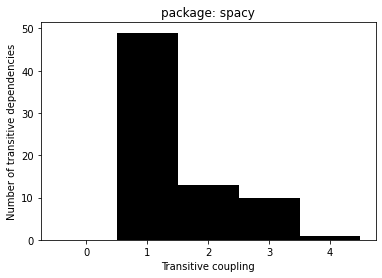

In [42]:
# Requires Matplotlib installed
import matplotlib.pyplot as plt
import numpy as np

cp = coupling_profile(pypi,'spacy')
ls = [len(cp[l]) for l in cp]
bins = np.arange(0, max(ls) + 1.5) - 0.5
plt.hist(ls,bins,color='black',histtype='stepfilled')
plt.xlabel('Transitive coupling')
plt.ylabel('Number of transitive dependencies')
plt.title('package: spacy')

You may also access coupling methods via *PackageInfoView*:

In [43]:
pypi['spacy'].coupling_interface_from('six')

{'ftfy', 'html5lib', 'six', 'thinc'}

In [44]:
pypi['six'].coupling_interface_to('spacy')

{'ftfy', 'html5lib', 'six', 'thinc'}

In [45]:
pypi['spacy'].coupling_profile()

{'hypothesis': {'thinc'},
 'thinc': {'thinc'},
 'html5lib': {'ftfy', 'html5lib'},
 'wrapt': {'thinc'},
 'dill': {'dill', 'thinc'},
 'regex': {'regex'},
 'funcsigs': {'thinc'},
 'appdirs': {'ftfy', 'html5lib', 'thinc'},
 'toolz': {'thinc'},
 'distribute': {'thinc'},
 'filelock': {'thinc'},
 'cloudpickle': {'cloudpickle', 'thinc'},
 'wget': {'wget'},
 'protobuf': {'thinc'},
 'text_unidecode': {'text_unidecode'},
 'xdis': {'thinc'},
 'ujson': {'ujson'},
 'itertoolz': {'thinc'},
 'pyparsing': {'ftfy', 'html5lib', 'thinc'},
 'termcolor': {'thinc'},
 'flexmock': {'thinc'},
 'six': {'ftfy', 'html5lib', 'six', 'thinc'},
 'murmurhash': {'murmurhash', 'preshed', 'thinc'},
 'thinc_gpu_ops': {'thinc'},
 'tqdm': {'thinc'},
 'mock': {'thinc'},
 'urllib3': {'requests'},
 'webencodings': {'ftfy', 'html5lib'},
 'spark-parser': {'thinc'},
 'certifi': {'requests'},
 'srsly': {'srsly', 'thinc'},
 'numpy': {'msgpack-numpy', 'numpy', 'thinc'},
 'chardet2': {'requests'},
 'pathlib': {'pathlib', 'thinc'},
 'a

### 02 - Strongly connected components

An strongly connected component (SCC) is a set of packages where each one depends transitively on every one else. So a defect in any package or in any dependency of any package in the SCC could affect the whole SCC.

A simple cycle of dependencies creates an SCC, but there can be much more complicated ones.

This is an example of a simple SCC:

<br>

![SCC](docs/img/scc.png "Strongly connected component")  

<br>

As OLIVIA internally uses the precomputed structure of SCCs of the dependency network, you can iterate immediatly over SCCs: 

In [46]:
scc_iterator = pypi.sccs()
print(next(scc_iterator))
print(next(scc_iterator))
print(next(scc_iterator))
print("...")

{'1pass'}
{'simple-pbkdf2'}
{'Alarmageddon'}
...


Each package forms its own SCC. PyPI has some small SCCs of size greater than one. These are the most interesting so OLIVIA provides a way of getting a list of SCCs in size order:

In [47]:
pypi.sorted_clusters()[:10]

[{'aws-cdk.assets',
  'aws-cdk.aws-lambda',
  'aws-cdk.aws-s3',
  'aws-cdk.aws-s3-assets',
  'aws-cdk.aws-s3-notifications',
  'aws-cdk.aws-sns',
  'aws-cdk.aws-sqs'},
 {'cloudtoken',
  'cloudtoken-plugin.json-exporter',
  'cloudtoken-plugin.saml',
  'cloudtoken-plugin.shell-exporter'},
 {'dash', 'dash-core-components', 'dash-html-components', 'dash-table'},
 {'SimpleSQLite', 'pytablereader', 'pytablewriter', 'sqliteschema'},
 {'classutils', 'configurationutil', 'fdutil', 'uiutil'},
 {'joker', 'joker-broker', 'joker-cast', 'joker-textmanip'},
 {'cs.debug', 'cs.queues', 'cs.result', 'cs.threads'},
 {'ogc', 'ogc-plugins-env', 'ogc-plugins-runner'},
 {'databasetools', 'dirutility', 'mysql-toolkit'},
 {'indb', 'metadb', 'metaform'}]

It is also possible to query which SCC a package belongs to, via PackageInfoView:

In [48]:
pypi['indb'].scc()

{'indb', 'metadb', 'metaform'}

It turns out that some networks have much larger SCCs

In [49]:
maven = OliviaNetwork(r'data/maven-2020-01-12.olv')

Maven Central, the package repository for Java (https://mvnrepository.com/) has a SCC of almost a thousand packages:

In [50]:
len(maven.sorted_clusters()[0])

981

### 03 - Network vulnerability

The vulnerability of the dependency network of software packages measures how sensitive the repository is to the random introduction of defects.

It is the average of some cost function over all the packages in the network, so it equals the expected cost of a random failure o defect, assuming a uniform failure probability.

We may use REACH as one of such cost functions. In this case, the vulnerability value would represent the expected number of packages potentially affected by a random failure.

The following figure shows several examples of simple networks with node values for REACH (R) and IMPACT (I) and below the corresponding REACH and IMPACT-vulnerability (preceded by the letter $\varphi$)

<br>

![Transitive coupling](docs/img/vulnerabilidad.png "Transitive coupling")  

<br>

In [51]:
from olivia.networkmetrics import *

failure_vulnerability(pypi)

Computing Reach



15.730114643659142

*failure_vulnerability* assumes REACH as cost function. As this model does not have a REACH cached, it is computed on the fly.  The calculation uses exact cost function values for each package in the network.  usually these functions have extremely skewed distributions, so average value is hard to sample.

PyPI has a REACH-vulnerability of about 16. This means that a random bug in a package could propagate in average to other 15 packages.

Maven is much more vulnerable to random failures, due to the presence of a significant size SCC.

In [52]:
failure_vulnerability(maven)

Computing Reach



1805.5391236430194

In [53]:
len(maven)

126752

Even considering the size difference, this is much worse that PyPI. At least other network, npm (https://www.npmjs.com/), the repository of Node.js, has even bigger relative values.

Other cost functions provide different perspectives on network vulnerability:

In [54]:
from olivia.packagemetrics import Impact

failure_vulnerability(pypi, metric=Impact)

Computing Impact



23.16392861363905

A single random failure on PyPI causes a expected potential value of 23 individual dependencies to fix. As REACH-vulnerability could reflect the propagation of defects, IMPACT-vulnerability gives an idea of the average effort needed to recover the network.


## C - Immunization
[01 - Immunization Delta](#01---Immunization-Delta)&ensp;|&ensp;[02 - Subcritical networks](#02---Selecting-Immunization-targets---Subcritical-networks)&ensp;|&ensp;[03 - Supercritical networks](#03---Selecting-Immunization-targets---Supercritical-networks)&ensp;|&ensp;[03 - Advanced](#03---Selecting-Immunization-targets---Advanced)

The vulnerability of package repositories can be lowered if we protect (immunize) certain packages against failure and propagation of failure. For example, we could subject a package or set of packages to very strict quality controls, security audits or even contractually shield certain non-functional requirements, such as the type of license. All this comes at a cost and it would be good to know which package sets are most cost-effective for reducing the vulnerability.

### 01 - Immunization Delta
Immunization Delta is the decrease in vulnerability of a network after immunizing a given set of packages. Take for example the following figure, which shows three simple network models and possible immunization sets (black nodes). Under each option the REACH and IMPACT-vulnerability and the corresponding immunization delta are shown.

<br>

![Inmunization](docs/img/inmunizacion.png "Simple inmunization examples")  

<br>

In [55]:
from olivia.model import OliviaNetwork
from olivia.immunization import *

pypi = OliviaNetwork(r'data/pypi-2020-01-12.olv')

In [56]:
failure_vulnerability(pypi)

Computing Reach



15.730114643659142

In [57]:
immunization_delta(pypi,{'numpy','pandas','matplotlib'})

Reach retrieved from metrics cache
Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done
Computing Reach



0.20080368750738664

By immunizing this set of three well known Python packages, we reduce the REACH-vulnerability by 0.20, i.e we reduce  by 0.20 the expected amount of potentially affected packages by a random failure (from 15.73 to 15.53). It is not a drastic reduction, but it is not bad either, for working only on three packages of about 50000.

The default algorithm of *immunizacion_delta(...)* is called *'network'*. It computes the cost function network-wide, immunizes the target set of packages provided, rebuilds the model, computes the cost function again and returns the diference in vulnerability. In the previous code example, you may notice that the first calculation was retrieved from the model's cache, as we had computed REACH just before by calling *failure_vulnerability(pypi)*.

This does not seem to be a particularly efficient method and indeed it is not. However, it is not clear that a better technique exists for calculating the immunization delta of arbitrary sets and cost functions.


For the particular case of the REACH cost function, OLIVIA provides another algorithm for the immunization delta computation, *'analytic'*. In this case, the entire network is not processed. A mathematical formulation that only considers the packages transitively related to the target set is used to analytically calculate the vulnerability reduction associated with its immunization. This can be way faster for certain type of immunization sets, but in large complex networks it is often not the case, and the *'network'* method is time-bound and better.

The two methods are exact but there may be small differences due to rounding.

In [58]:
target = {'networkx','spacy'}

In [59]:
%time immunization_delta(pypi, target)

Reach retrieved from metrics cache
Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done
Computing Reach

CPU times: user 11 s, sys: 150 ms, total: 11.2 s
Wall time: 11.4 s


0.06565417799314766

In [60]:
%time immunization_delta(pypi, target, algorithm='analytic')

CPU times: user 1.4 s, sys: 14.6 ms, total: 1.42 s
Wall time: 1.42 s


0.06565417799314502

Of course you may be interested on computing immunizacion delta according to another cost metric:

In [61]:
immunization_delta(pypi,{'numpy','pandas','matplotlib'}, cost_metric = Impact)

Computing Impact

Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done
Computing Impact



0.2860969940511353

Notice how we needed to compute IMPACT twice. However the values for the original network are cached and will be reused in subsequent queries:

In [62]:
immunization_delta(pypi,{'six'}, cost_metric = Impact)

Impact retrieved from metrics cache
Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done
Computing Impact



0.9497498325651037

### 02 - Selecting Immunization targets - Subcritical networks
OLIVIA includes tools to help locate good immunization sets in package dependency networks. 

Subcritical networks do not have many dependency cycles, and the largest strongly connected component (SCC) is small, logarithmic in relation to the size of the repository. PyPI is subcritical.

From here on we will deal with REACH-vulnerability unless we note otherwise.

¿How effective is to immunize random packages?

In [63]:
failure_vulnerability(pypi)

Reach retrieved from metrics cache


15.730114643659142

In [64]:
immunization_delta(pypi, iset_random(pypi, 20), algorithm='analytic')

0.009632431154709846

*iset_...* methods from *olivia.immunization* produce sets of packages intended as immunization targets. *iset_random(...)* is really more like a baseline tool, selecting uniformly arbitrary ones. The immunization of 20 random packages does not seem to do much for decreasing the vulnerability (-0.0066 out of 15.73 in this case)

In [65]:
immunization_delta(pypi, iset_random(pypi, 1000), algorithm='analytic')

0.7955127447504236

Although appreciable, the immunization of 1000 random packages does not look spectacular either. *iset_random(...)* also provides an option to make an indirect selection, that is select randomly chosen dependencies of randomly chosen packages. This is a well known immunization tactic from Network Science, often used to exemplify advanced vaccination strategies. In this case it is also much better that pure random selection.

In [66]:
immunization_delta(pypi, iset_random(pypi, 20, indirect=True), algorithm='analytic')

2.721644407674428

If we look at it, this indirect strategy is in fact a probabilistic approach to selection based on the number of dependents. Here we can just try the exact approach:

In [67]:
target = pypi.get_metric(DependentsCount).top(20)
target

Computing Dependents Count


[('requests', 10623),
 ('six', 5014),
 ('numpy', 3911),
 ('click', 2519),
 ('setuptools', 2117),
 ('python-dateutil', 1873),
 ('pyyaml', 1836),
 ('PyYAML', 1572),
 ('lxml', 1368),
 ('future', 1218),
 ('pandas', 1202),
 ('urllib3', 1180),
 ('pytz', 1092),
 ('boto3', 1070),
 ('beautifulsoup4', 1057),
 ('pytest', 1045),
 ('Django', 995),
 ('django', 945),
 ('Click', 933),
 ('jinja2', 899)]

In [68]:
immunization_delta(pypi, {l[0] for l in target}, algorithm='analytic')

5.278276799432692

*iset_naive_ranking(...)* is a shortcut to select a set of nodes based simply on a ranking over a metricStats object:

In [69]:
immunization_delta(pypi, 
                   iset_naive_ranking(20, pypi.get_metric(DependentsCount)),
                   algorithm='analytic')

DependentsCount retrieved from metrics cache


5.278276799432692

Choosing the 20 packages with higher count of direct dependants is even better that indirect selection. Now we achieve a vulnerability reduction of near a third, acting only on 20 out of 50.000 packages.

If we want to reduce REACH-vulnerability, a simple idea to consider could be to immunize the nodes with the greatest REACH value. It is somewhat surprising that this strategy is worse than the dependants count based one:

In [70]:
immunization_delta(pypi, 
                   iset_naive_ranking(20, pypi.get_metric(Reach)),
                   algorithm='analytic')

Reach retrieved from metrics cache


4.87391167316708

In addition to ranking methods, OLIVIA provides some specific techniques to find good targets. *iset_delta_set_reach(...)* computes a set of nodes that meets certain theoretical constraints on REACH and SURFACE values to ensure that it contains the best single node to immunize from the network. It is possible that the set contains other good targets.

The size of the delta set is given by the algorithm. For PyPI it is really small, of only 18 packages.

In [71]:
delta_set = iset_delta_set_reach(pypi)
print(delta_set)

Reach retrieved from metrics cache
Computing Surface

Reach retrieved from metrics cache
Surface retrieved from metrics cache
{'s3transfer', 'jsonschema', 'requests', 'pluggy', 'pytest', 'pbr', 'zipp', 'distribute', 'packaging', 'setuptools', 'wheel', 'importlib-metadata', 'notebook', 'ipykernel', 'configparser', 'boto3', 'keyring', 'cryptography'}


In [72]:
immunization_delta(pypi, delta_set, algorithm='analytic')

6.401134617657488

This is our best result so far, a 6.40 out of 15.73 (41%) decrease in vulnerability by immunizing 18 packages.

Of course we can also rank the results within the delta set for finding smaller sets:

In [73]:
smaller = iset_naive_ranking(4, pypi.get_metric(DependentsCount), subset = delta_set)
print(smaller)
immunization_delta(pypi, smaller, algorithm='analytic')

DependentsCount retrieved from metrics cache
{'pytest', 'boto3', 'requests', 'setuptools'}


3.6809872749477996

### 03 - Selecting Immunization targets - Supercritical networks

Supercritical packet dependency networks are those that contain a strongly connected (SCC) component of significant size. Maven is one of them.

In [74]:
maven = OliviaNetwork(r'data/maven-2020-01-12.olv')

Supercritical networks are much more vulnerable, because the big SCC contributes greatly to the propagation of defects.

In [75]:
failure_vulnerability(maven)

Computing Reach



1805.5391236430194

Lets see what happens if we immunize the delta set for Maven:

In [76]:
maven_delta_set = iset_delta_set_reach (maven)
immunization_delta(maven, maven_delta_set)

Reach retrieved from metrics cache
Computing Surface

Reach retrieved from metrics cache
Surface retrieved from metrics cache
Reach retrieved from metrics cache
Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done
Computing Reach



1800.3279159303206

We reduced the vulnerability of Maven by 1800!. This means that before immunization, the failure of a single package could affect an average of 1805 other packages. After immunization, this number is 5 (five packages).

However, there is a catch.

In [77]:
len(maven_delta_set)

6540

In supercrítical networks, the delta set is larger. Here it represent aproximately 5% of the network (was 0.04% in PyPI). In fact, the delta set is not very useful in supercritical networks, as it usually contains the largest SCC, which is the real cause of the high vulnerability.

*iset_sap(...)* computes an immunization set by detecting the strong articulation points (SAP) of the biggest SCC in the network. SAPs are packages whose immunization is likely to contribute to the break-up of the SCC, reducing its ability to spread defects.

In [ ]:
sap = iset_sap(maven)

immunization_delta(maven, sap)

Reach retrieved from metrics cache
Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done
Computing Reach
     Processing node: 125K      


1695.3186300807877

In [ ]:
len(sap)

351

SAP is much smaller (0.28%), and still achieves a reduction in vulnerability of near 94%

Note that here we have not used the 'analityc' method for the calculation of the immunization delta, since sets are larger and it could be really slow.

Ranking on the SAP set gives us a tool for finding smaller sets:

In [ ]:
immunization_delta(maven, iset_naive_ranking(100, maven.get_metric(DependentsCount), subset=sap))

DependentsCount retrieved from metrics cache
Reach retrieved from metrics cache
Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done
Computing Reach
     Processing node: 125K      


1544.4391883362787

Notice that the SAP approach is completely innefective in subcritical networks

In [ ]:
immunization_delta(pypi, iset_sap(pypi), algorithm='analytic')

0.013040223771815782

Even the immunization of the largest SCC in full has a negligible effect on the network's vulnerability

In [ ]:
immunization_delta(pypi, pypi.sorted_clusters()[0], algorithm='analytic')

0.019717921443485796

### 03 - Selecting Immunization targets - Advanced

Calculating the immunization delta is computationally expensive and the problem of selecting an optimal immunization set of a given size is mathematically intractable for large repositories.

In this guide we have used PyPI and Maven, but there are much larger networks, such as npm with over a million packages.

We will now give some ideas of additional techniques that can be used for the heuristic exploration of the problem.

#### Manipulating immunization sets

Set operations may be interesting to facilitate the experimental search for good immunization sets.

Packages both in PyPI delta set and in top 100 by dependentsCount:

In [ ]:
delta_set & iset_naive_ranking(100, pypi.get_metric(DependentsCount))

DependentsCount retrieved from metrics cache


{'boto3',
 'configparser',
 'cryptography',
 'jsonschema',
 'packaging',
 'pbr',
 'pytest',
 'requests',
 'setuptools',
 'wheel'}

In [ ]:
immunization_delta(pypi, {'boto3',
                         'configparser',
                         'cryptography',
                         'jsonschema',
                         'packaging',
                         'pbr',
                         'pytest',
                         'requests',
                         'setuptools',
                         'wheel'}, algorithm='analytic')

5.7339360989638735

That approach is much better than simply selecting the top 10 packages by DependentsCount:

In [ ]:
immunization_delta(pypi,
                   iset_naive_ranking(10, pypi.get_metric(DependentsCount)), 
                   algorithm='analytic')

DependentsCount retrieved from metrics cache


3.7312768388291375

#### Ranking by compound metrics

Since arithmetic operations can be performed with MetricStats objects, it is easy to employ ranking functions with compound metrics. For example, REACH*SURFACE is a theoretical upper bound of immunization delta.

In [ ]:
upper = iset_naive_ranking(50, pypi.get_metric(Reach)*pypi.get_metric(Surface))
immunization_delta(pypi, upper, algorithm='analytic')

Reach retrieved from metrics cache
Surface retrieved from metrics cache


8.024760666587873

In fact, in this case we can get exactly the PyPI delta set, using this technique with the added benefit of being able to regulate the number of elements in the set.

In [ ]:
len(delta_set)

18

In [ ]:
upper = iset_naive_ranking(18, pypi.get_metric(Reach)*pypi.get_metric(Surface))

Reach retrieved from metrics cache
Surface retrieved from metrics cache


In [ ]:
# void set
delta_set-upper

set()

#### Brute force and Greedy selection

Once we get small enough candidate sets, we could try brute-force and greedy approaches for finding smaller sets. 

Considering the PyPI delta set, let's see which package individually contributes most to vulnerability reduction:

In [ ]:
[(i, immunization_delta(pypi, {i}, algorithm='analytic')) for i in delta_set]

[('importlib-metadata', 1.3886065476893985),
 ('requests', 1.6734625536776582),
 ('setuptools', 0.9829807351376906),
 ('zipp', 0.3518496631603829),
 ('distribute', 0.2246582358271284),
 ('pytest', 0.7602135287397077),
 ('boto3', 0.3025450104400583),
 ('packaging', 0.6895757002718355),
 ('pbr', 0.34966316038293344),
 ('ipykernel', 0.05127447504235118),
 ('cryptography', 0.4491982823149352),
 ('s3transfer', 0.06293582318874838),
 ('jsonschema', 0.5747350588976874),
 ('pluggy', 0.06888468660126856),
 ('configparser', 0.3583894732695111),
 ('keyring', 0.25920891935547413),
 ('notebook', 0.1722018673915613),
 ('wheel', 0.5350037426624118)]

It should be noted that, as the sets of dependants and transitional dependencies are interrelated, the immunization delta is not additive. For example, if you take out *'importlib-metadata'* from the delta set, immunization delta decreases only by a small amount:

In [ ]:
immunization_delta(pypi, delta_set-{'importlib-metadata'}, algorithm='analytic')

6.274553835244061

#### Using other centrality measures

Common measures of centrality in the field of network science, or more custom or specific ones, can be used to select immunization sets. You may need to narrow down the set of candidates to  make the computation feasible.

For example, using betweenness centrality on the SAP set gives the best results we have found for small immunization sets in Maven:

In [ ]:
import networkx as nx

# Using the NetworkX implementation of betweenness centrality
# You can access the full NetworkX network underlying the repository using OliviaModel.network.
# Here we restrict the centrality computation to the subgraph induced by the SAP set:
sap_betweenness = nx.betweenness_centrality(maven.network.subgraph(sap))

In [ ]:
from olivia.packagemetrics import MetricStats

# Build a MetricStats object to use in iset_naive_ranking
# MetricStats constructor admits a dictionary of values such as those produced by NetworkX
sap_betweenness = MetricStats(sap_betweenness)

In [ ]:
immunization_delta(maven, iset_naive_ranking(10, sap_betweenness))

Reach retrieved from metrics cache
Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done
Computing Reach
     Processing node: 125K      


471.4254134057055

Follows a visual representation of this technique. The drawn portion (981 nodes) is the biggest SCC of Maven , representing about 0.8% of the network. 

The highlighted white nodes correspond to the SAP set (351 nodes), whose immunization reduces by 93.9% the REACH-vulnerability of the network as a whole. The blue highlights are the 10 SAP with the highest out-degree centrality (number of dependants) and the red ones the 10 with the highest betweenness. By immunizing these sets, a reduction in network vulnerability of 13% and 26% respectively is achieved.
The representation omits the direction of the arcs and uses the Kamada-kawai algorithm.

<br>

![Maven SCC](docs/img/maven.png "SAP immunization of Maven with betweenness ranking")  

<br>